In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

## Establishing a Baseline Performance

#### Importing the OHLCV dataset into a Pandas DataFrame.

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv("emerging_markets_ohlcv.csv", 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


#### Generating trading signals using short- and long-window SMA values.

In [4]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [6]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<Axes: title={'center': 'Strategy Returns'}, xlabel='date'>

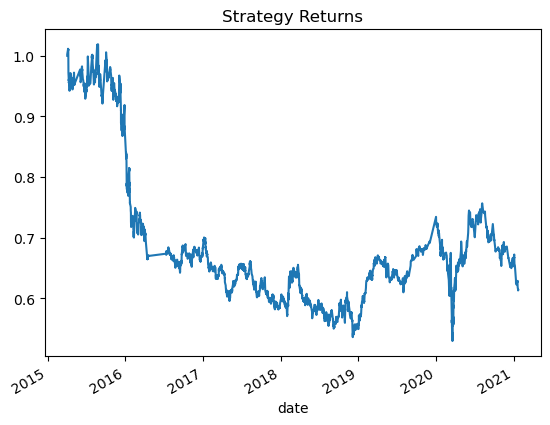

In [8]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot(title = "Strategy Returns")

#### Splitting the data into training and testing datasets.

In [9]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [10]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [11]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [12]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [13]:
 # Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463
...,...,...
2015-06-30 12:15:00,24.2150,25.2106
2015-06-30 14:00:00,24.1050,25.1930
2015-06-30 14:15:00,24.0775,25.1767


In [14]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test

,SMA_Fast,SMA_Slow
date,,
2015-07-06 10:00:00,24.1250,25.09190
2015-07-06 10:45:00,23.9700,25.06820
2015-07-06 14:15:00,23.8475,25.04580
2015-07-06 14:30:00,23.6725,25.02060
2015-07-07 11:30:00,23.4800,24.99510
...,...,...
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445


In [15]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Using the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data, make predictions based on the testing data and reviewing the predictions.

In [16]:
# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

# Display the sample predictions
testing_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Reviewing the classification report associated with the SVC model predictions.

In [17]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



#### Creating a predictions DataFrame that contains columns for "Predicted" values, "Actual Returns", and "Strategy Returns".

In [18]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals_df["Actual Returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


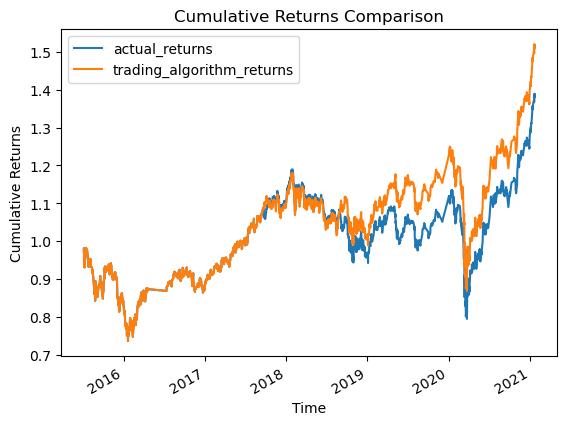

In [19]:
# Calculate and plot the cumulative returns for the actual returns and the trading algorithm returns
cumulative_returns = (1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod()
cumulative_returns.plot()

# Set plot title and labels
plt.title('Cumulative Returns Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')

# Save the plot as a PNG image
plt.savefig('./Plots/baseline_cumulative_returns_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG with higher resolution

# Show the plot
plt.show()

## Tuning the Baseline Performance

* Tuning the training algorithm by adjusting the size of the training dataset.
* Tuning the trading algorithm by adjusting the SMA input features.
* Choosing the set of parameters that best improved the trading algorithm returns.

## Evaluating a New Machine Learning Classifier - Logistic Regression

In [20]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

#### Using the logistic regression model method to fit the training data, make predictions based on the testing data and reviewing the predictions.

In [21]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression(random_state=1)

# Fit the model to the data using X_train_scaled and y_train
logistic_regression_model = logistic_regression_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions_logistic = logistic_regression_model.predict(X_test_scaled)

# Display the sample predictions
testing_signal_predictions_logistic[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Reviewing the classification report associated with the logistic regression model predictions.

In [22]:
# Evaluate the model using a classification report
lr_testing_report = classification_report(y_test, testing_signal_predictions_logistic)

# Display report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38      1804
         1.0       0.56      0.66      0.61      2288

    accuracy                           0.52      4092
   macro avg       0.50      0.50      0.49      4092
weighted avg       0.51      0.52      0.51      4092



#### Creating a predictions DataFrame that contains columns for "Predicted" values, "Actual Returns", and "Strategy Returns".

In [23]:
# Create a predictions DataFrame
lr_predictions_df = pd.DataFrame(index=X_test.index)

lr_predictions_df["predicted_signal"] = testing_signal_predictions_logistic

lr_predictions_df["actual_returns"] = signals_df["Actual Returns"]

lr_predictions_df["trading_algorithm_returns"] = (
    lr_predictions_df["actual_returns"] * lr_predictions_df["predicted_signal"]
)

# Review the DataFrame
lr_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


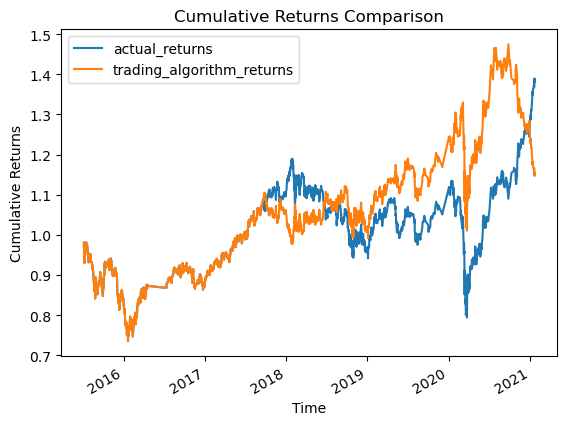

In [24]:
# Calculate and plot the cumulative returns for the actual returns and the trading algorithm returns
lr_cumulative_returns = (1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod()
lr_cumulative_returns.plot()

# Set plot title and labels
plt.title('Cumulative Returns Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')

# Save the plot as a PNG image
plt.savefig('./Plots/lr_cumulative_returns_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG with higher resolution

# Show the plot
plt.show()